# 7. Analyzing Training, Validation, and Testing Sets
Plotting some distributions of the test set.

In [32]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib
#from repeating_classifier_training_utils import *
from functools import reduce

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)

sys.path.append("../../..")
sys.path.append("../..")
sys.path.append("..")

from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *


%load_ext autoreload
%matplotlib inline
%autoreload 2
from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Load test set

In [3]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
original_labels = np.array(f['labels'])

# filtered_eventdata = original_eventdata[test_filtered_indices]
test_energies = original_energies[test_filtered_indices]
test_positions = original_positions[test_filtered_indices]
test_angles = original_angles[test_filtered_indices]
test_labels = original_labels[test_filtered_indices]
test_radius = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]
f.close()

test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 
             'angles':test_angles, 'labels':test_labels, 'radius':test_radius}

## Load Training/Validation Sets

In [4]:
trainval_data_path='/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval.h5'
trainval_idxs_path='/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval_idxs.npz'

idxs = np.load(trainval_idxs_path,allow_pickle=True)
train_idxs = idxs['train_idxs']
val_idxs = idxs['val_idxs']

f = h5py.File(trainval_data_path,'r')
tv_hdf5_event_data = (f["event_data"])
tv_eventdata = np.memmap(trainval_data_path, mode="r", shape=tv_hdf5_event_data.shape,
                                    offset=tv_hdf5_event_data.id.get_offset(), dtype=tv_hdf5_event_data.dtype)

tv_energies = np.array(f['energies'])
tv_positions = np.array(f['positions'])
tv_angles = np.array(f['angles'])
tv_labels = np.array(f['labels'])

train_energies = tv_energies[train_idxs]
train_positions = tv_positions[train_idxs]
train_angles = tv_angles[train_idxs]
train_labels = tv_labels[train_idxs]
train_radius = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 
              'angles':train_angles, 'labels':train_labels, 'radius':train_radius}

val_energies = tv_energies[val_idxs]
val_positions = tv_positions[val_idxs]
val_angles = tv_angles[val_idxs]
val_labels = tv_labels[val_idxs]
val_radius = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 
            'angles':val_angles, 'labels':val_labels, 'radius':val_radius}

In [5]:
dataset_info = [train_info,val_info,test_info]

In [6]:
print(np.sum([dataset['labels'].shape[0] for dataset in dataset_info]))

8377548


In [7]:
np.savez('./old_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'],
         test_radii=test_info['radius'])

## Distribution of event energies

In [8]:
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26

In [9]:
shifted_energies = []
for idx in range(3):
    shifted_energies.append(np.zeros(dataset_info[idx]['labels'].shape[0]))
    g_idxs = np.where(dataset_info[idx]['labels']==0)[0]
    e_idxs = np.where(dataset_info[idx]['labels']==1)[0]
    m_idxs = np.where(dataset_info[idx]['labels']==2)[0]
    shifted_energies[idx][g_idxs] = np.squeeze(dataset_info[idx]['energies'][g_idxs] - GAMMA_THRESHOLD)
    shifted_energies[idx][e_idxs] = np.squeeze(dataset_info[idx]['energies'][e_idxs] - ELECTRON_THRESHOLD)
    shifted_energies[idx][m_idxs] = np.squeeze(dataset_info[idx]['energies'][m_idxs] - MUON_THRESHOLD)

<Figure size 432x288 with 0 Axes>

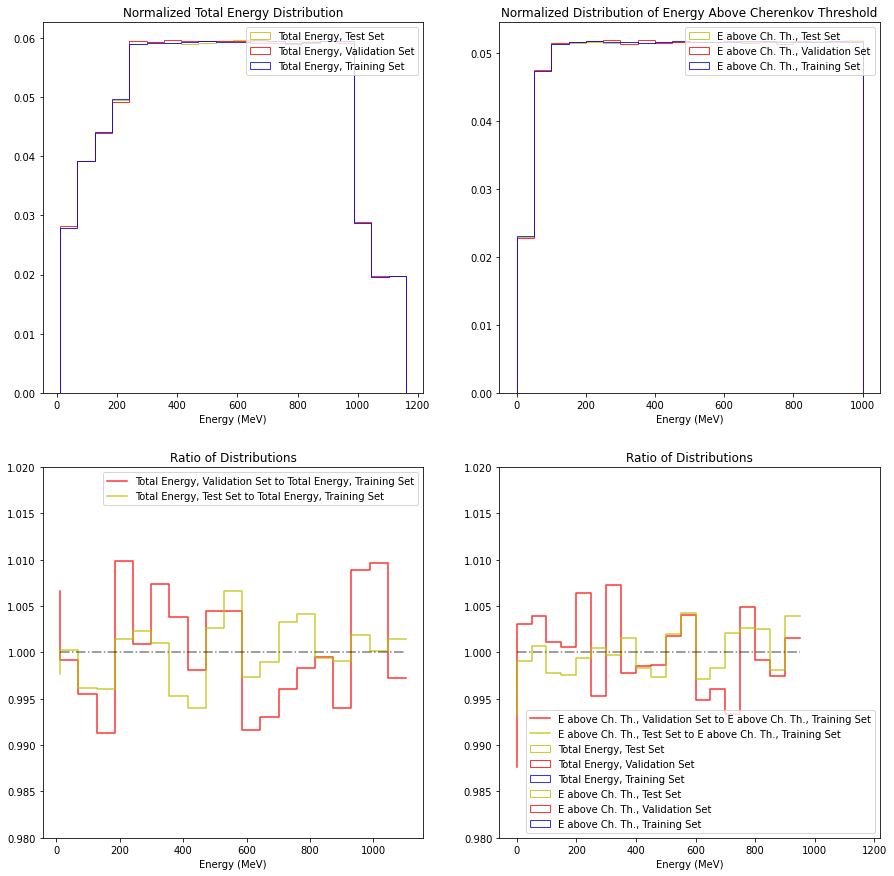

In [10]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()
ax = axes[0]
plot_compare_dists([np.squeeze(data['energies']) for data in dataset_info], [1,2],[0,0],
                   ['Total Energy, {}'.format(data['name'])for data in dataset_info],
                   colors=('b','r','y'),ratio_range=[0.98,1.02],title='Normalized Total Energy Distribution',
                   xlabel='Energy (MeV)',axes=axes[[0,2]]
        )
plot_compare_dists([shifted_energies[i] for i in range(3)], [1,2],[0,0],
                   ['E above Ch. Th., {}'.format(data['name'])for data in dataset_info],
                   colors=('b','r','y'),ratio_range=[0.98,1.02],title='Normalized Distribution of Energy Above Cherenkov Threshold',
                   xlabel='Energy (MeV)',axes=axes[[1,3]]
        )

### Gamma Events

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 432x288 with 0 Axes>

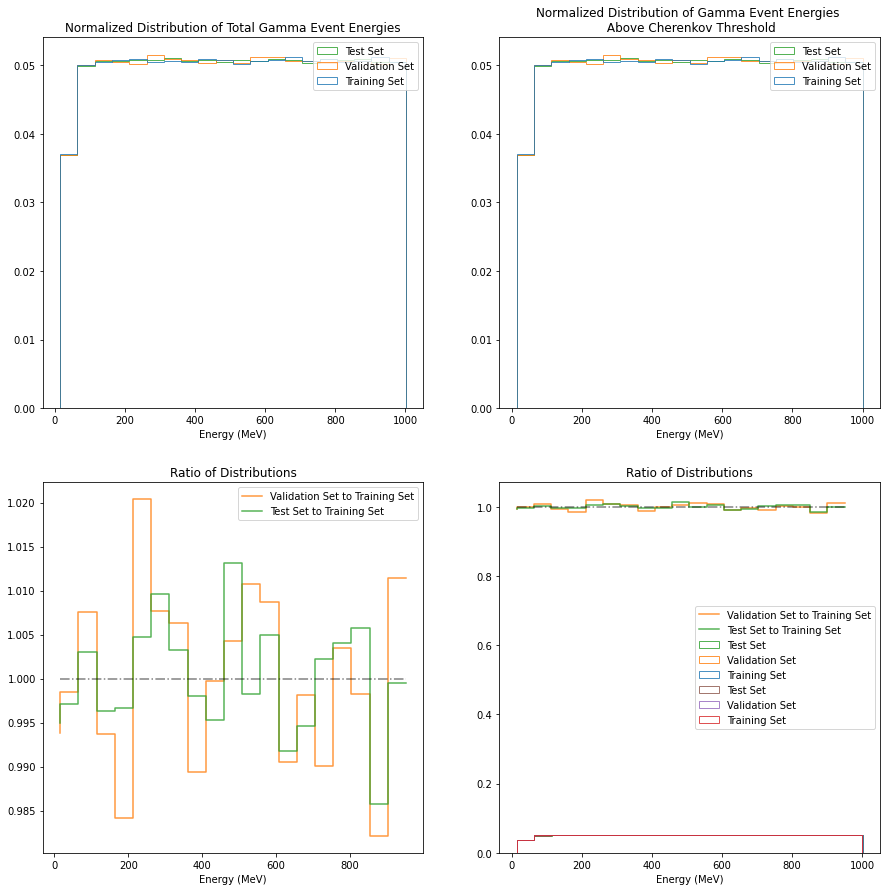

In [11]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()
train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs = np.where(dataset_info[2]['labels']==0)[0]

plot_compare_dists(np.squeeze(np.array(
                    [dataset_info[0]['energies'][train_g_idxs],
                    dataset_info[1]['energies'][val_g_idxs],
                    dataset_info[2]['energies'][test_g_idxs]])),
                    [1,2],[0,0],[data['name'] for data in dataset_info],
                    title='Normalized Distribution of Total Gamma Event Energies', axes = axes[[0,2]],
                    xlabel='Energy (MeV)'
                    )
plot_compare_dists(np.squeeze(np.array([shifted_energies[0][train_g_idxs],
                    shifted_energies[1][val_g_idxs],
                    shifted_energies[2][test_g_idxs]])),
                    [1,2],[0,0],[data['name'] for data in dataset_info],
                    title='Normalized Distribution of Gamma Event Energies \n Above Cherenkov Threshold', axes = axes[[1,3]],
                    xlabel='Energy (MeV)'
                    )

### Electron Events

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 432x288 with 0 Axes>

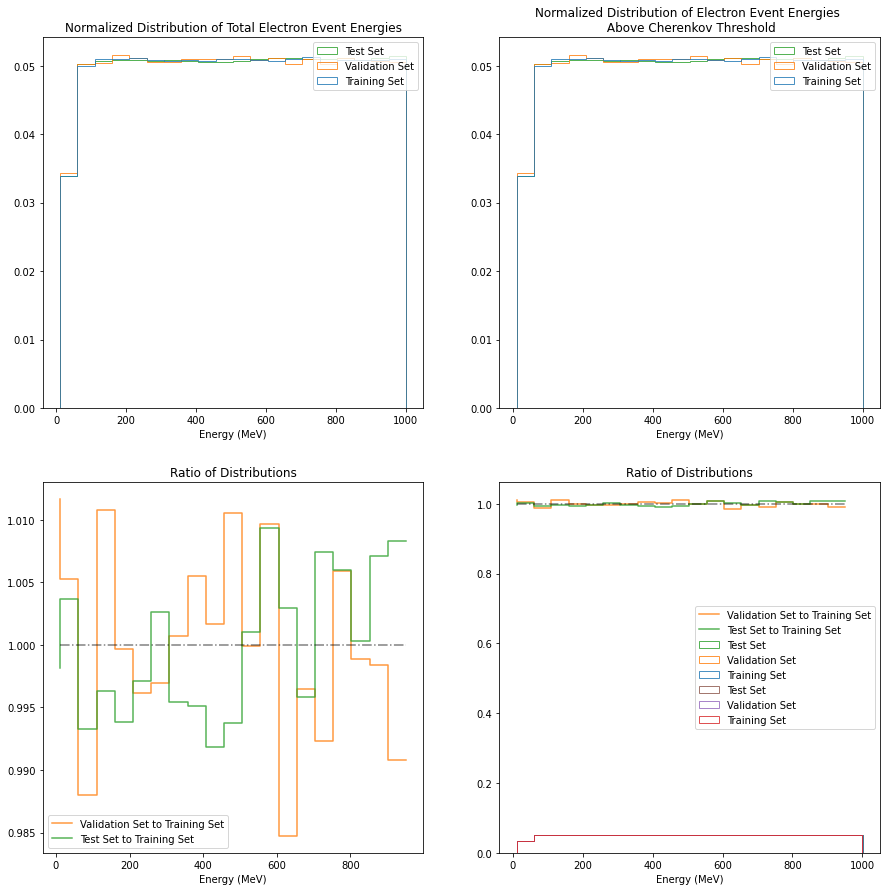

In [12]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()
train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs = np.where(dataset_info[2]['labels']==1)[0]

plot_compare_dists(np.squeeze(np.array(
                    [dataset_info[0]['energies'][train_e_idxs],
                     dataset_info[1]['energies'][val_e_idxs],
                     dataset_info[2]['energies'][test_e_idxs]])),
                    [1,2],[0,0],[data['name'] for data in dataset_info],
                    title='Normalized Distribution of Total Electron Event Energies', axes = axes[[0,2]],
                    xlabel='Energy (MeV)'
                    )
plot_compare_dists(np.squeeze(np.array(
                    [shifted_energies[0][train_e_idxs],
                     shifted_energies[1][val_e_idxs],
                    shifted_energies[2][test_e_idxs]])),
                    [1,2],[0,0],[data['name'] for data in dataset_info],
                    title='Normalized Distribution of Electron Event Energies \n Above Cherenkov Threshold', 
                    axes = axes[[1,3]], xlabel='Energy (MeV)'
                    )

### Muon Events

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 432x288 with 0 Axes>

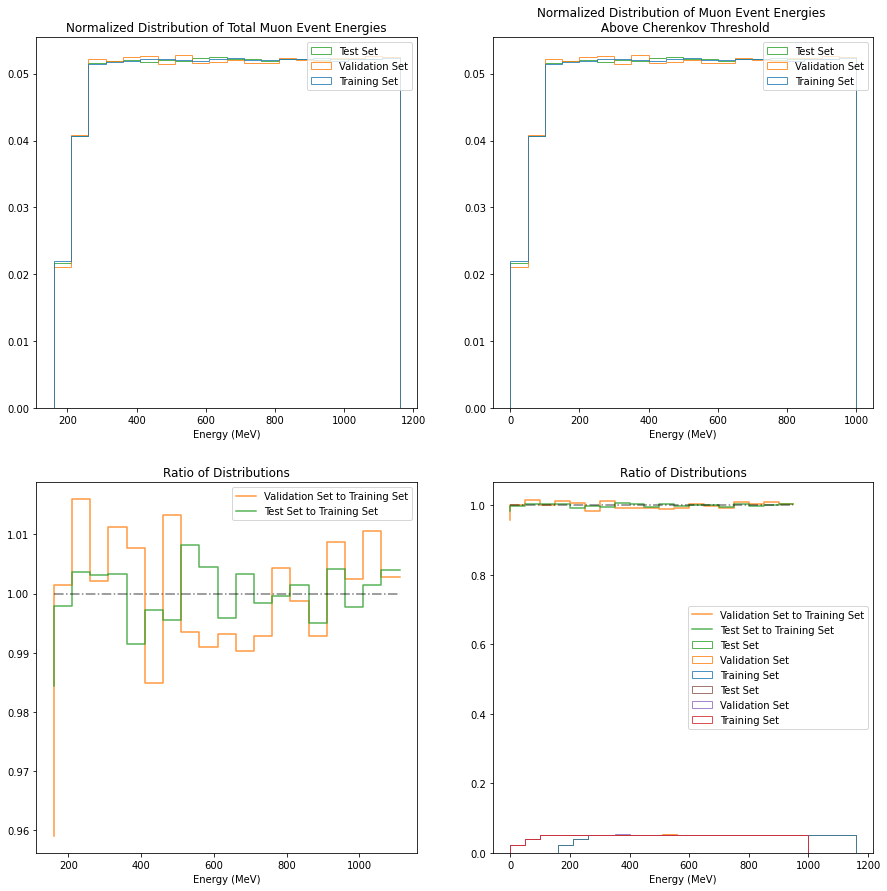

In [13]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()
train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs = np.where(dataset_info[2]['labels']==2)[0]

plot_compare_dists(np.squeeze(np.array(
                    [dataset_info[0]['energies'][train_m_idxs],
                     dataset_info[1]['energies'][val_m_idxs],
                    dataset_info[2]['energies'][test_m_idxs]])),
                    [1,2],[0,0],[data['name'] for data in dataset_info],
                    title='Normalized Distribution of Total Muon Event Energies', axes = axes[[0,2]],
                    xlabel='Energy (MeV)'
                    )
plot_compare_dists(np.squeeze(np.array(
                    [shifted_energies[0][train_m_idxs],shifted_energies[1][val_m_idxs],
                    shifted_energies[2][test_m_idxs]])),
                    [1,2],[0,0],[data['name'] for data in dataset_info],
                    title='Normalized Distribution of Muon Event Energies \n Above Cherenkov Threshold', 
                    axes = axes[[1,3]], xlabel='Energy (MeV)'
                    )

## Distribution of total charge

In [14]:
"""
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Training Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(train_idxs))
pbar.start()
for i in range(len(train_idxs)):
    pbar.update(i)
    event_data = tv_eventdata[train_idxs[i]]
    #print(event_data.shape)
    event_sum = np.sum(event_data[:, :, 0:19])
    #print(event_sum)
    total_charge.append(event_sum)
pbar.finish()
dataset_info[0]['total_charge'] = total_charge

np.savez('./old_dataset_data/training_set_total_charge.npz',total_charge=dataset_info[0]['total_charge'])
"""

"\ntotal_charge = []\n\npbar = ProgressBar(widgets=['Calculating Total Charge for Training Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=len(train_idxs))\npbar.start()\nfor i in range(len(train_idxs)):\n    pbar.update(i)\n    event_data = tv_eventdata[train_idxs[i]]\n    #print(event_data.shape)\n    event_sum = np.sum(event_data[:, :, 0:19])\n    #print(event_sum)\n    total_charge.append(event_sum)\npbar.finish()\ndataset_info[0]['total_charge'] = total_charge\n\nnp.savez('training_set_total_charge.npz',total_charge=dataset_info[0]['total_charge'])\n"

In [16]:
dataset_info[0]['total_charge'] = np.load('./old_dataset_data/training_set_total_charge.npz',allow_pickle=True)['total_charge']

In [17]:
"""
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(val_idxs))
pbar.start()
for i in range(len(val_idxs)):
    pbar.update(i)
    event_data = tv_eventdata[val_idxs[i]]
    #print(event_data.shape)
    event_sum = np.sum(event_data[:, :, 0:19])
    #print(event_sum)
    total_charge.append(event_sum)
pbar.finish()
dataset_info[1]['total_charge'] = total_charge

np.savez('./old_dataset_data/validation_set_total_charge.npz',total_charge=dataset_info[1]['total_charge'])
"""

"\ntotal_charge = []\n\npbar = ProgressBar(widgets=['Calculating Total Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=len(val_idxs))\npbar.start()\nfor i in range(len(val_idxs)):\n    pbar.update(i)\n    event_data = tv_eventdata[val_idxs[i]]\n    #print(event_data.shape)\n    event_sum = np.sum(event_data[:, :, 0:19])\n    #print(event_sum)\n    total_charge.append(event_sum)\npbar.finish()\ndataset_info[1]['total_charge'] = total_charge\n\nnp.savez('./old_dataset_data/validation_set_total_charge.npz',total_charge=dataset_info[1]['total_charge'])\n"

In [18]:
dataset_info[1]['total_charge'] = np.load('./old_dataset_data/validation_set_total_charge.npz',allow_pickle=True)['total_charge']

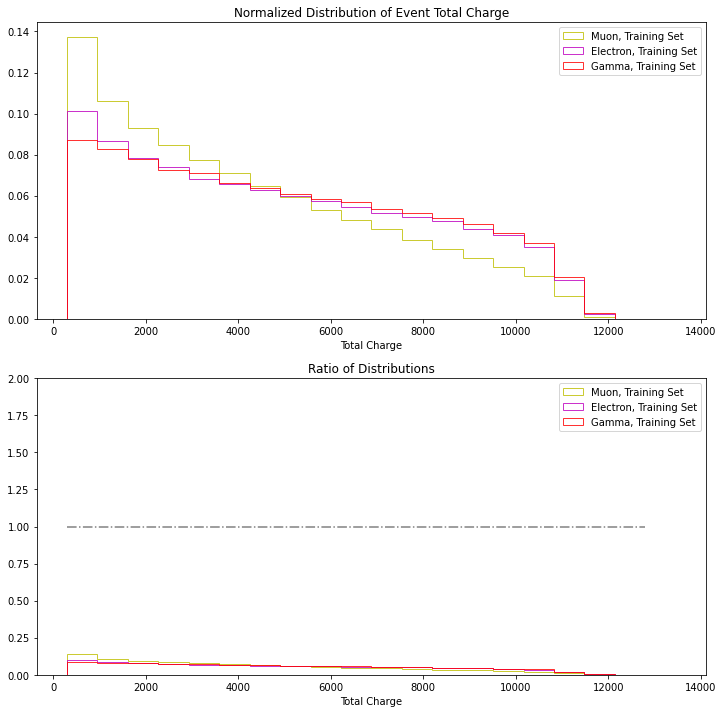

In [19]:
fig = plot_compare_dists([
                    dataset_info[1]['total_charge'][val_g_idxs],
                    dataset_info[1]['total_charge'][val_e_idxs],
                    dataset_info[1]['total_charge'][val_m_idxs]],
                    [],[],['Gamma, Training Set', 'Electron, Training Set', 'Muon, Training Set'],
                    ratio_range=[0,2],title='Normalized Distribution of Event Total Charge',
                    colors=['r','m','y'],
                    linestyle=['-','-','-'],
                    xlabel='Total Charge'
                    )

../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[dist_idxs_reference[i]],
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[dist_idxs_reference[i]],


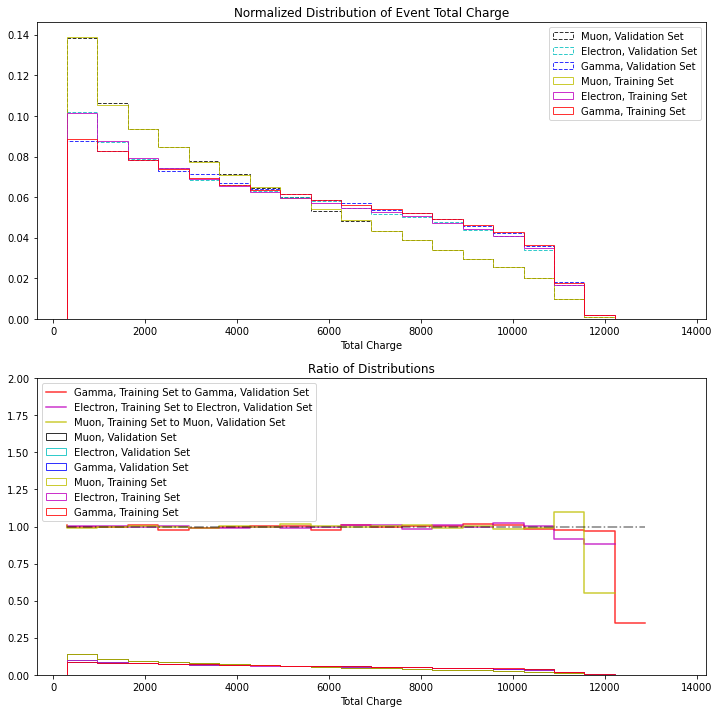

In [20]:
train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]

val_g_idxs = np.where(dataset_info[1]['labels']==0)[0]
val_e_idxs = np.where(dataset_info[1]['labels']==1)[0]
val_m_idxs = np.where(dataset_info[1]['labels']==2)[0]

fig = plot_compare_dists([
                    dataset_info[0]['total_charge'][train_g_idxs],
                    dataset_info[0]['total_charge'][train_e_idxs],
                    dataset_info[0]['total_charge'][train_m_idxs],
                    dataset_info[1]['total_charge'][val_g_idxs],
                    dataset_info[1]['total_charge'][val_e_idxs],
                    dataset_info[1]['total_charge'][val_m_idxs]],
                    [0,1,2],[3,4,5],
                    ['Gamma, Training Set', 'Electron, Training Set', 'Muon, Training Set',
                                     'Gamma, Validation Set', 'Electron, Validation Set', 'Muon, Validation Set'],
                    ratio_range=[0,2],
                    title='Normalized Distribution of Event Total Charge',
                    colors=['r','m','y','b','c','k'],
                    linestyle=['-','-','-','--','--','--'],
                    xlabel='Total Charge'
                    )

<Figure size 432x288 with 0 Axes>

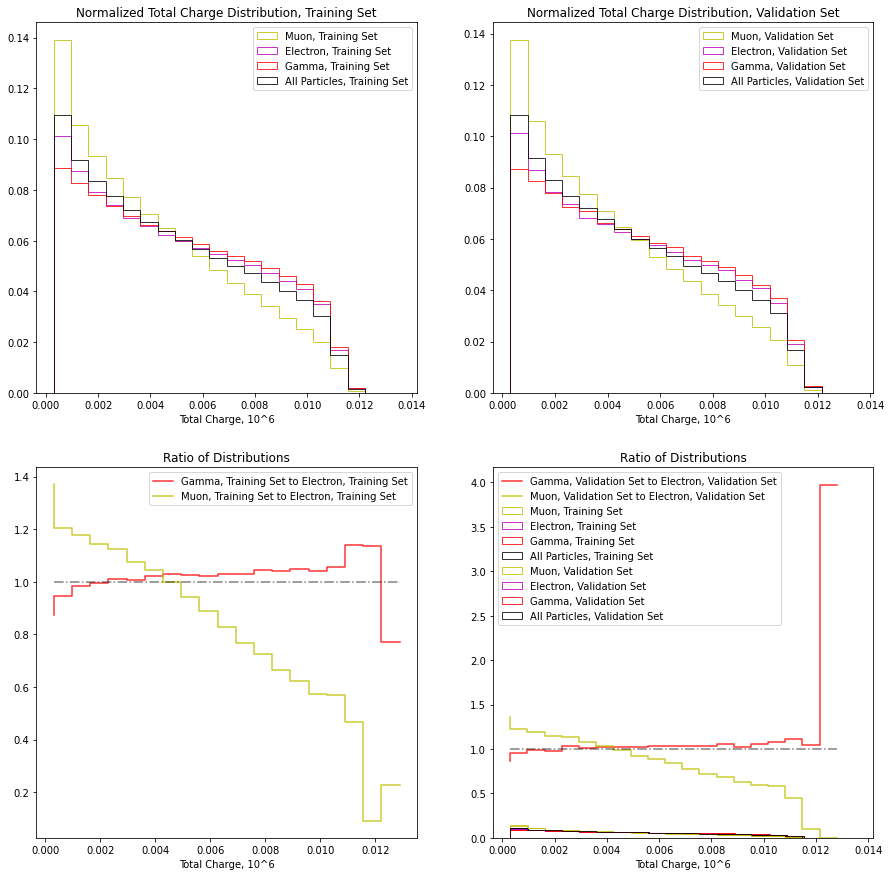

In [21]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()
N_BINS = 40

for i in range(2):
    g_idxs = np.where(dataset_info[i]['labels']==0)[0]
    e_idxs = np.where(dataset_info[i]['labels']==1)[0]
    m_idxs = np.where(dataset_info[i]['labels']==2)[0]
    plot_compare_dists((dataset_info[i]['total_charge']/10**6,
                         dataset_info[i]['total_charge'][g_idxs]/10**6,
                         dataset_info[i]['total_charge'][e_idxs]/10**6,
                         dataset_info[i]['total_charge'][m_idxs]/10**6),
                         [1,3],[2,2], ['All Particles, {}'.format(dataset_info[i]['name']), 'Gamma, {}'.format(dataset_info[i]['name']),
                         'Electron, {}'.format(dataset_info[i]['name']),'Muon, {}'.format(dataset_info[i]['name'])],
                         colors = ('k','r','m','y'), axes = axes[[i,i+2]],
                         title='Normalized Total Charge Distribution, {}'.format(dataset_info[i]['name']),
                         xlabel='Total Charge, 10^6'
                           )    

In [22]:
# total_charge = []

# pbar = ProgressBar(widgets=['Calculating Total Charge for Testing Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
#            ' ', ETA()], maxval=len(test_filtered_indices))
# pbar.start()
# for i in range(len(test_filtered_indices)):
#     pbar.update(i)
#     total_charge.append(np.sum(original_eventdata[test_filtered_indices[i]]))
# pbar.finish()
# dataset_info[2]['total_charge'] = total_charge

## Distribution of event departure angles

<Figure size 432x288 with 0 Axes>

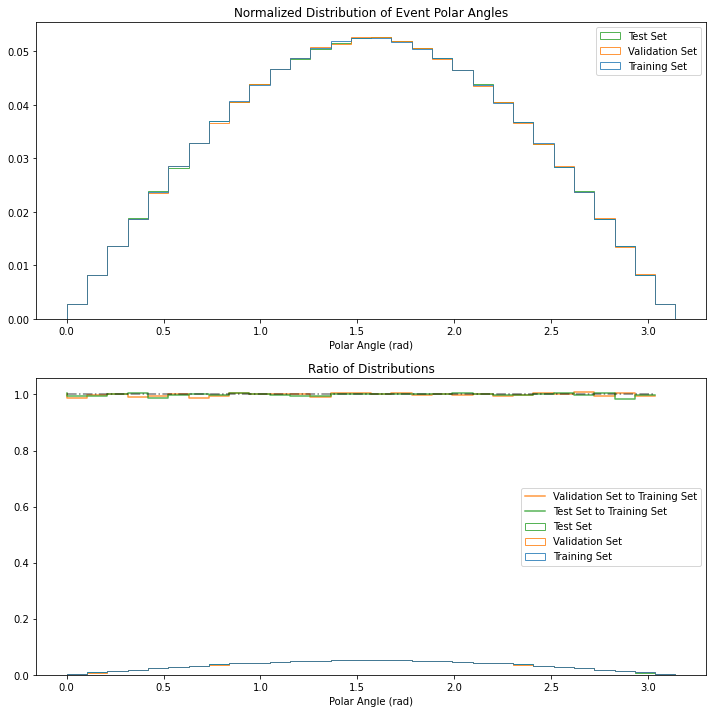

In [23]:
plt.figure()
fig,axes = plt.subplots(2,1,figsize=(12,12))
axes = axes.flatten()
plot_compare_dists(([data['angles'][:,0] for data in dataset_info]),[1,2],[0,0],[data['name'] for data in dataset_info],
                    bins=30,title='Normalized Distribution of Event Polar Angles',axes=axes, xlabel='Polar Angle (rad)')

<Figure size 432x288 with 0 Axes>

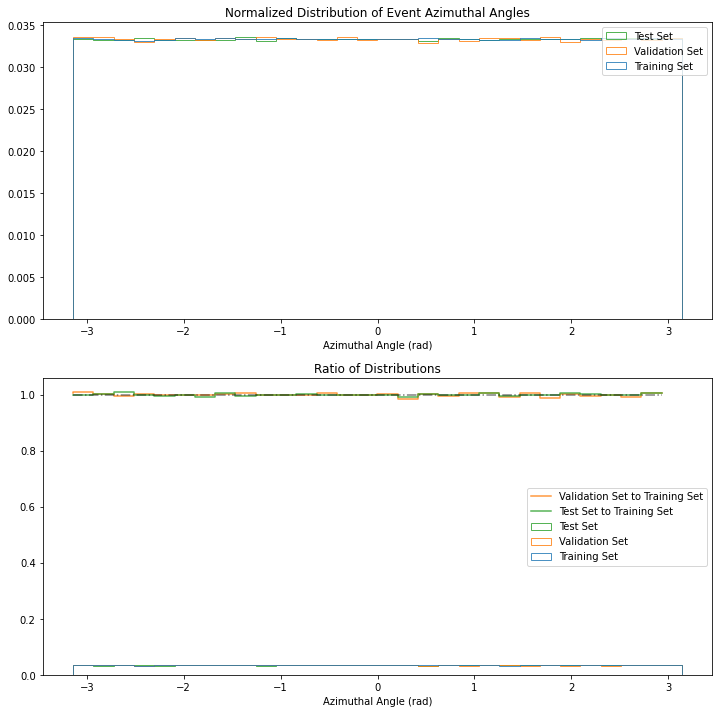

In [24]:
plt.figure()
fig,axes = plt.subplots(2,1,figsize=(12,12))
axes = axes.flatten()
plot_compare_dists(([data['angles'][:,1] for data in dataset_info]),[1,2],[0,0],[data['name'] for data in dataset_info],
                    bins=30,title='Normalized Distribution of Event Azimuthal Angles',axes=axes, xlabel='Azimuthal Angle (rad)')

<Figure size 432x288 with 0 Axes>

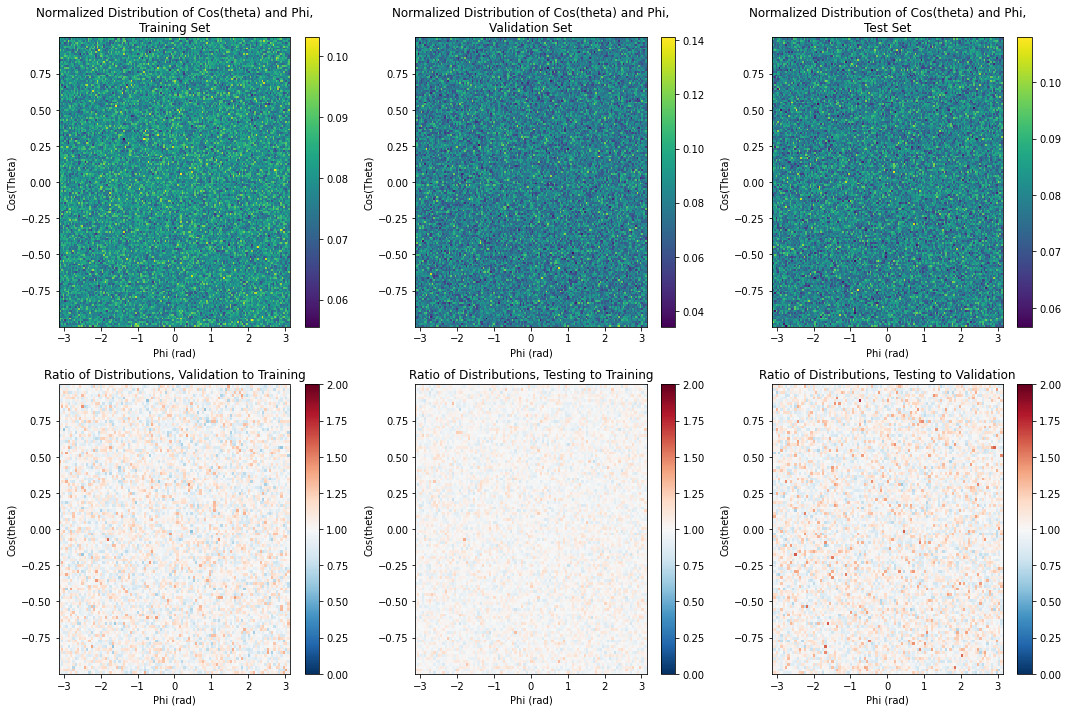

In [25]:
plt.figure()
fig,axes = plt.subplots(2,3,figsize=(15,10))
axes = axes.flatten()
for idx in range(3):
    ax = axes[idx]
    mat,_,_,im = ax.hist2d(dataset_info[idx]['angles'][:,1], np.cos(dataset_info[idx]['angles'][:,0]),[150,150],density=True)
    fig.colorbar(im,ax=ax)
    ax.set_title('Normalized Distribution of Cos(theta) and Phi,\n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Cos(Theta)')
    ax.set_xlabel('Phi (rad)')

fig = plot_2d_ratio(dataset_info[1]['angles'][:,1], np.cos(dataset_info[1]['angles'][:,0]),
                      dataset_info[0]['angles'][:,1], np.cos(dataset_info[0]['angles'][:,0]),bins=(100,100),
                      title='Ratio of Distributions, Validation to Training',ylabel='Cos(theta)',xlabel='Phi (rad)',
                      fig=fig, ax=axes[3],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['angles'][:,1], np.cos(dataset_info[2]['angles'][:,0]),
                      dataset_info[0]['angles'][:,1], np.cos(dataset_info[0]['angles'][:,0]),bins=(100,100),
                      title='Ratio of Distributions, Testing to Training',ylabel='Cos(theta)',xlabel='Phi (rad)',
                      fig=fig, ax=axes[4],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['angles'][:,1], np.cos(dataset_info[2]['angles'][:,0]),
                      dataset_info[1]['angles'][:,1], np.cos(dataset_info[1]['angles'][:,0]),bins=(100,100),
                      title='Ratio of Distributions, Testing to Validation',ylabel='Cos(theta)',xlabel='Phi (rad)',
                      fig=fig, ax=axes[5],ratio_range=[0,2])

plt.tight_layout()
plt.show()

## Distribution of events throughout the detector volume

<Figure size 432x288 with 0 Axes>

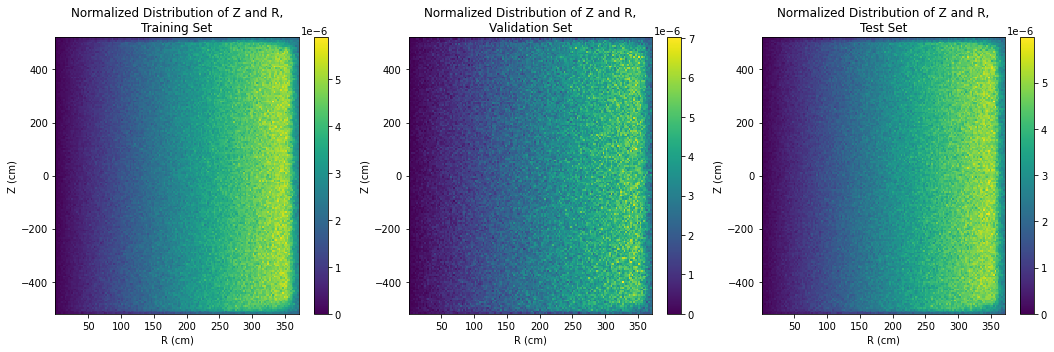

In [26]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(15,5))
for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(dataset_info[idx]['radius'], dataset_info[idx]['positions'][:,0,1],[150,150],density=True)
    fig.colorbar(im,ax=ax)
    ax.set_title('Normalized Distribution of Z and R,\n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Z (cm)')
    ax.set_xlabel('R (cm)')
plt.tight_layout()
plt.show()

../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:944: RuntimeWarning: invalid value encountered in true_divide
  ratio = ns_1/ns_2
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:944: RuntimeWarning: divide by zero encountered in true_divide
  ratio = ns_1/ns_2


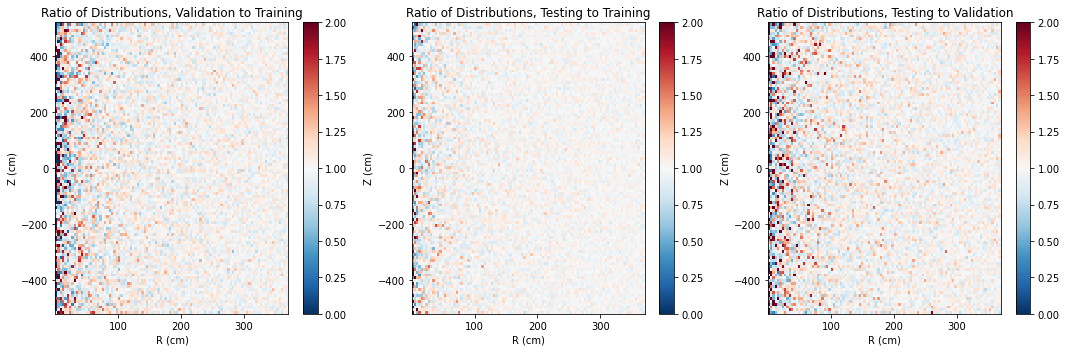

In [27]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
fig = plot_2d_ratio(dataset_info[1]['radius'], dataset_info[1]['positions'][:,0,1],
                      dataset_info[0]['radius'], dataset_info[0]['positions'][:,0,1],bins=(100,100),
                      title='Ratio of Distributions, Validation to Training',xlabel='R (cm)',ylabel='Z (cm)',
                      fig=fig, ax=axes[0],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['radius'], dataset_info[2]['positions'][:,0,1],
                      dataset_info[0]['radius'], dataset_info[0]['positions'][:,0,1],bins=(100,100),
                      title='Ratio of Distributions, Testing to Training',xlabel='R (cm)',ylabel='Z (cm)',
                      fig=fig, ax=axes[1],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['radius'], dataset_info[2]['positions'][:,0,1],
                      dataset_info[1]['radius'], dataset_info[1]['positions'][:,0,1],bins=(100,100),
                      title='Ratio of Distributions, Testing to Validation',xlabel='R (cm)',ylabel='Z (cm)',
                      fig=fig, ax=axes[2],ratio_range=[0,2])
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

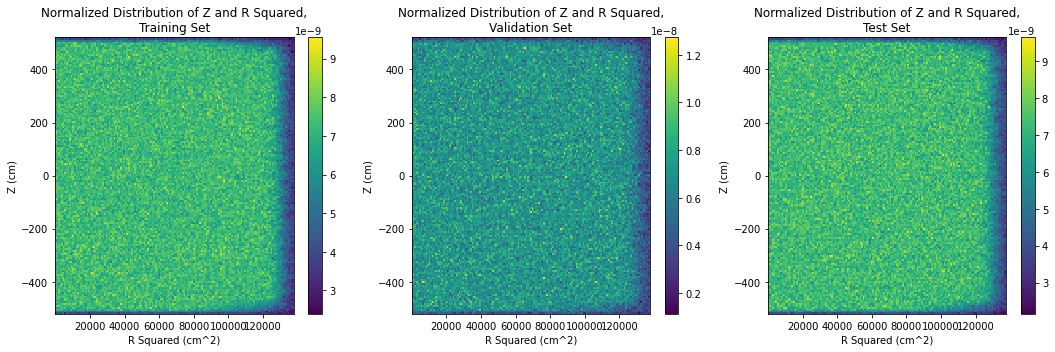

In [28]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(15,5))
bins=(150,150)
for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(list(map(lambda x : x**2,dataset_info[idx]['radius'])), 
                           dataset_info[idx]['positions'][:,0,1],bins,density=True)
    fig.colorbar(im,ax=ax)
    ax.set_title('Normalized Distribution of Z and R Squared,\n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Z (cm)')
    ax.set_xlabel('R Squared (cm^2)')
plt.tight_layout()
plt.show()

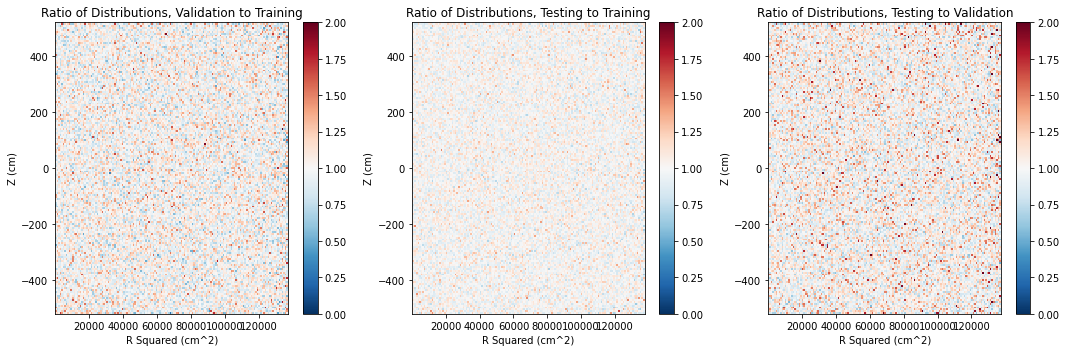

In [29]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
bins=(150,150)
fig = plot_2d_ratio(list(map(lambda x : x**2,dataset_info[1]['radius'])), dataset_info[1]['positions'][:,0,1],
                      list(map(lambda x : x**2,dataset_info[0]['radius'])), dataset_info[0]['positions'][:,0,1],
                      bins=bins,
                      title='Ratio of Distributions, Validation to Training',xlabel='R Squared (cm^2)',ylabel='Z (cm)',
                      fig=fig, ax=axes[0],ratio_range=[0,2])
fig = plot_2d_ratio(list(map(lambda x : x**2,dataset_info[2]['radius'])), dataset_info[2]['positions'][:,0,1],
                      list(map(lambda x : x**2,dataset_info[0]['radius'])), dataset_info[0]['positions'][:,0,1],
                      bins=bins,
                      title='Ratio of Distributions, Testing to Training',xlabel='R Squared (cm^2)',ylabel='Z (cm)',
                      fig=fig, ax=axes[1],ratio_range=[0,2])
fig = plot_2d_ratio(list(map(lambda x : x**2,dataset_info[2]['radius'])), dataset_info[2]['positions'][:,0,1],
                      list(map(lambda x : x**2,dataset_info[1]['radius'])), dataset_info[1]['positions'][:,0,1],bins=bins,
                      title='Ratio of Distributions, Testing to Validation',xlabel='R Squared (cm^2)',ylabel='Z (cm)',
                      fig=fig, ax=axes[2],ratio_range=[0,2])
plt.tight_layout()

## Display some randomly selected test event data from edge events

In [30]:
border_event_idxs = []
i = 0
search_idxs = np.random.permutation(len(test_radius))
while len(border_event_idxs) < 3:
    if test_radius[search_idxs[i]] > 360:
        border_event_idxs.append(search_idxs[i])
    i+=1

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  after removing the cwd from sys.path.


0.011580578512396694


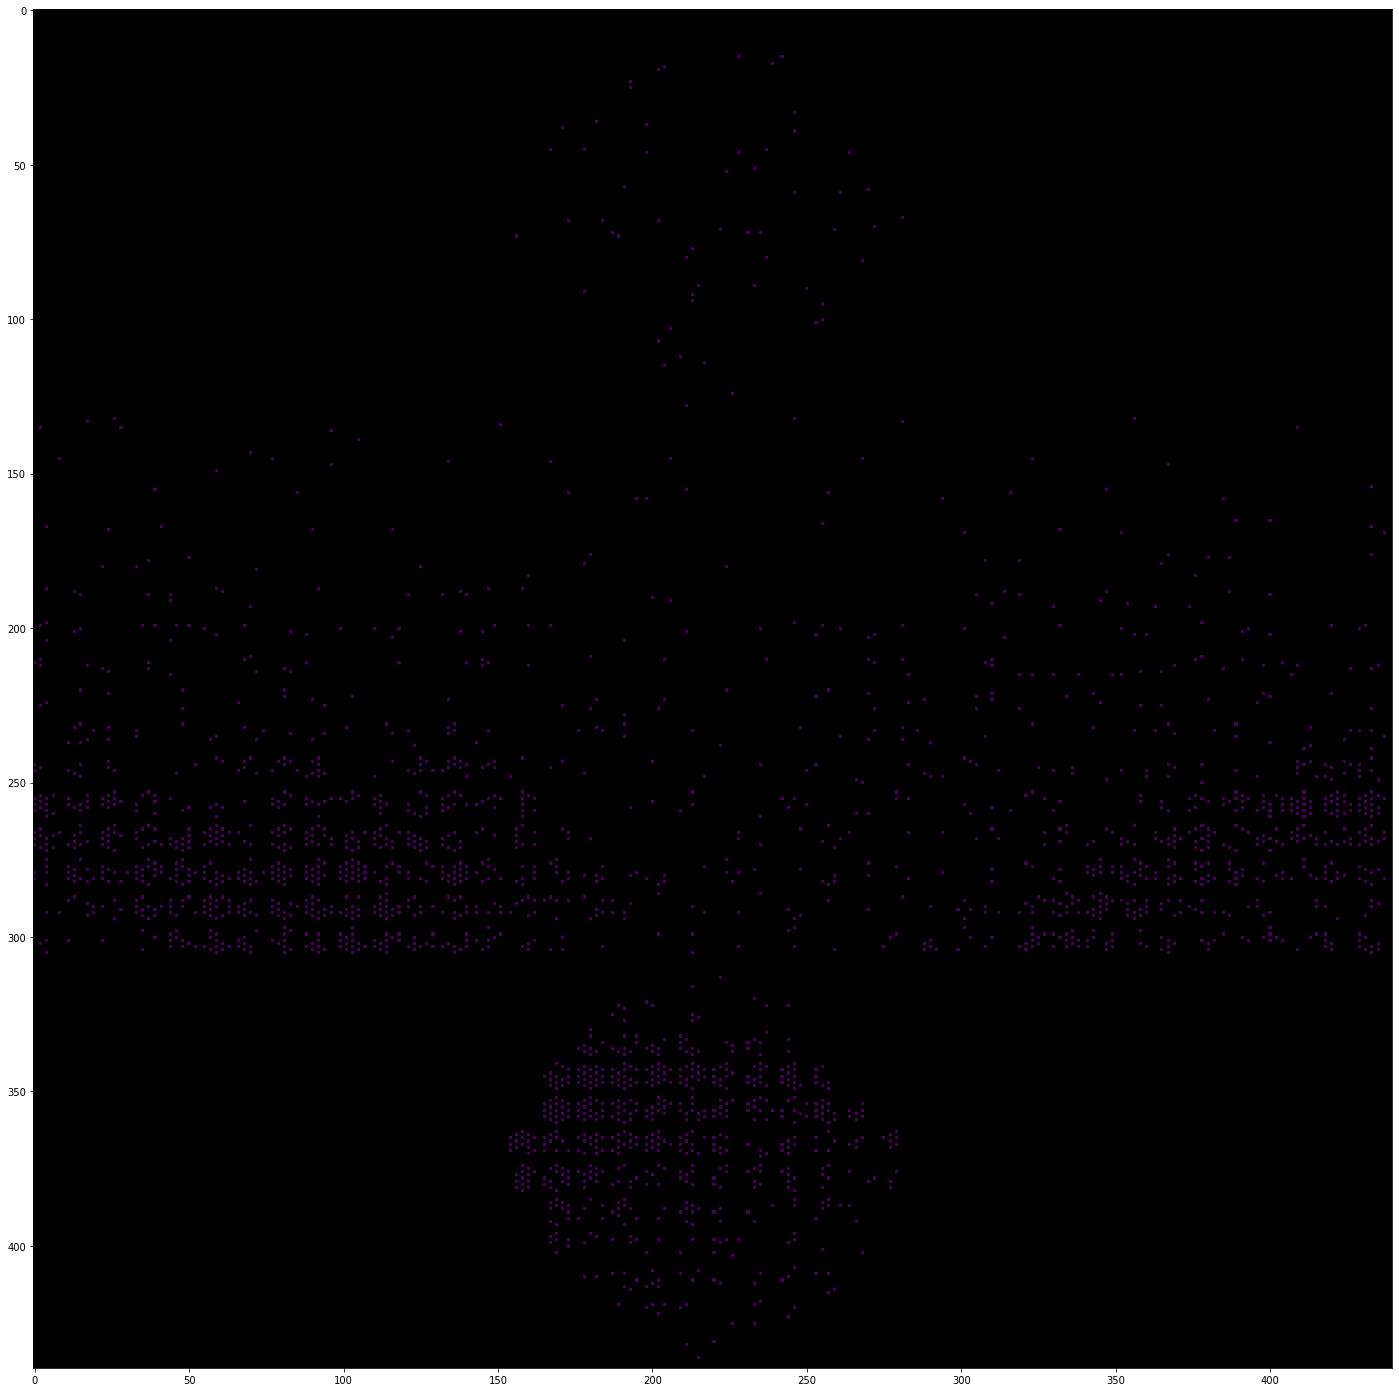

In [33]:
from WatChMaL.analysis.plot_utils import get_plot_array
fig, axes = plt.subplots(1,1,figsize=(25,25),facecolor='w')
cmap = plt.cm.viridis
cmap.set_bad(color='black')
ax = axes
a=get_plot_array(original_eventdata[test_filtered_indices[np.random.randint(0,high=test_filtered_indices.shape[0])],:,:,0:19])
print(len(np.where(a>0)[0])/(440**2))
#     a = np.ma.masked_where(a < 0.05, a)
ax.imshow(a,
           origin="upper",
           cmap=cmap,
           norm=matplotlib.colors.LogNorm(vmax=np.amax(a),
                                         clip=True))
plt.show()

In [37]:
plt.savefig('./old_dataset_data/flattened.pdf')

<Figure size 432x288 with 0 Axes>

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  after removing the cwd from sys.path.


0.017701446280991736
0.006110537190082645
0.0012964876033057851


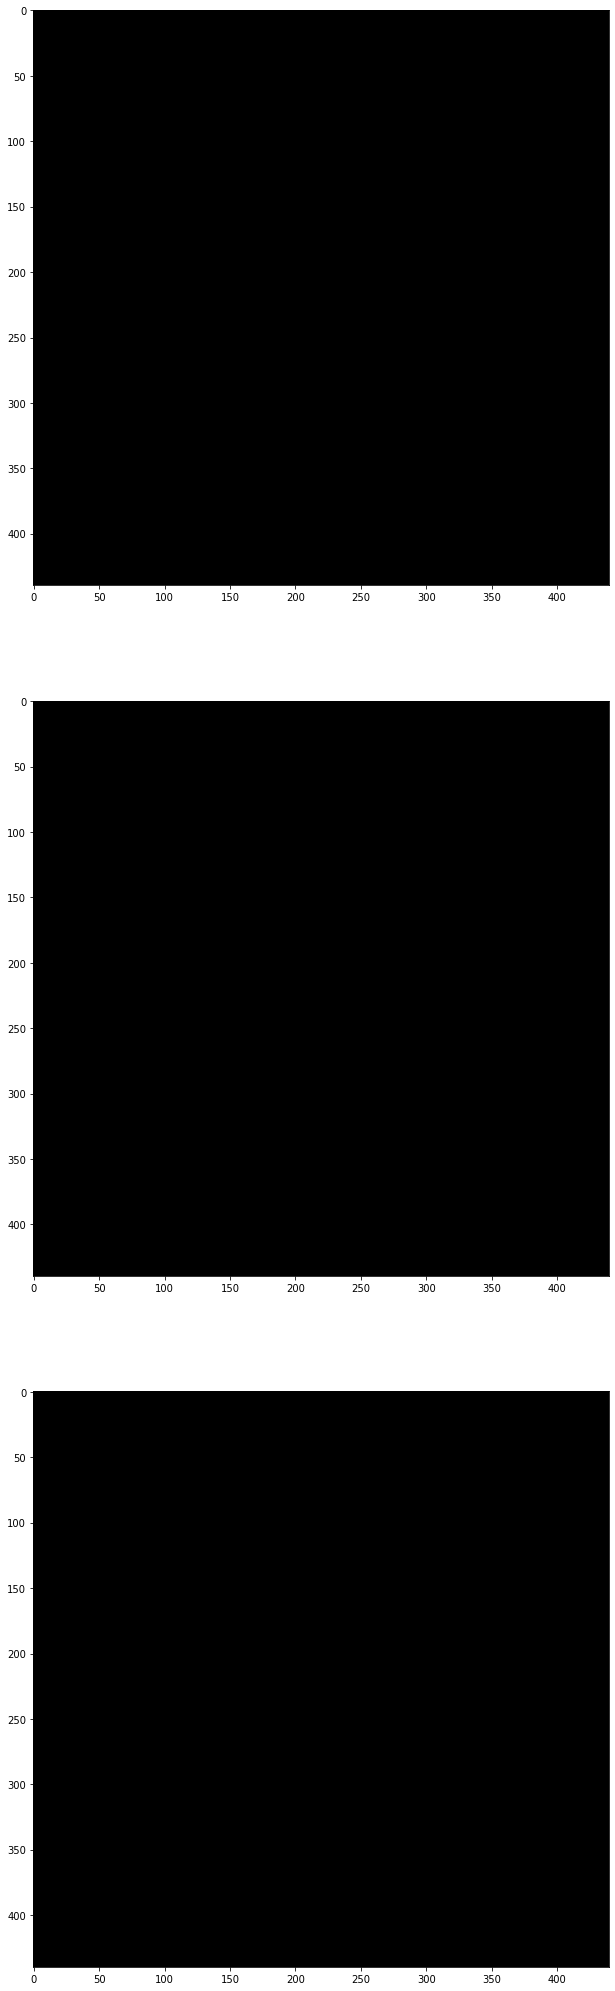

In [38]:
fig, axes = plt.subplots(3,1,figsize=(18,12*3),facecolor='w')
axes = axes.flatten()
cmap = plt.cm.viridis
cmap.set_bad(color='black')
for idx in range(len(axes)):
    ax = axes[idx]
    a=get_plot_array(original_eventdata[test_filtered_indices[border_event_idxs[idx]],:,:,0:19])
    print(len(np.where(a>0)[0])/(440**2))
    a = np.ma.masked_where(a < 0.05, a)
    ax.imshow(a,
               origin="upper",
               cmap=cmap,
               norm=matplotlib.colors.LogNorm(vmax=np.amax(a),
                                             clip=True))
plt.show()

## Display some randomly selected test event data from middle-of-tank events

In [39]:
middle_event_idxs = []
i = 0
search_idxs = np.random.permutation(len(test_radius))
while len(middle_event_idxs) < 3:
    if test_radius[search_idxs[i]] < 50 and np.pi/4 < test_angles[i][0] < 3/4*np.pi:
        middle_event_idxs.append(search_idxs[i])
    i+=1

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  after removing the cwd from sys.path.


0.012634297520661157
0.018083677685950414
0.00962809917355372


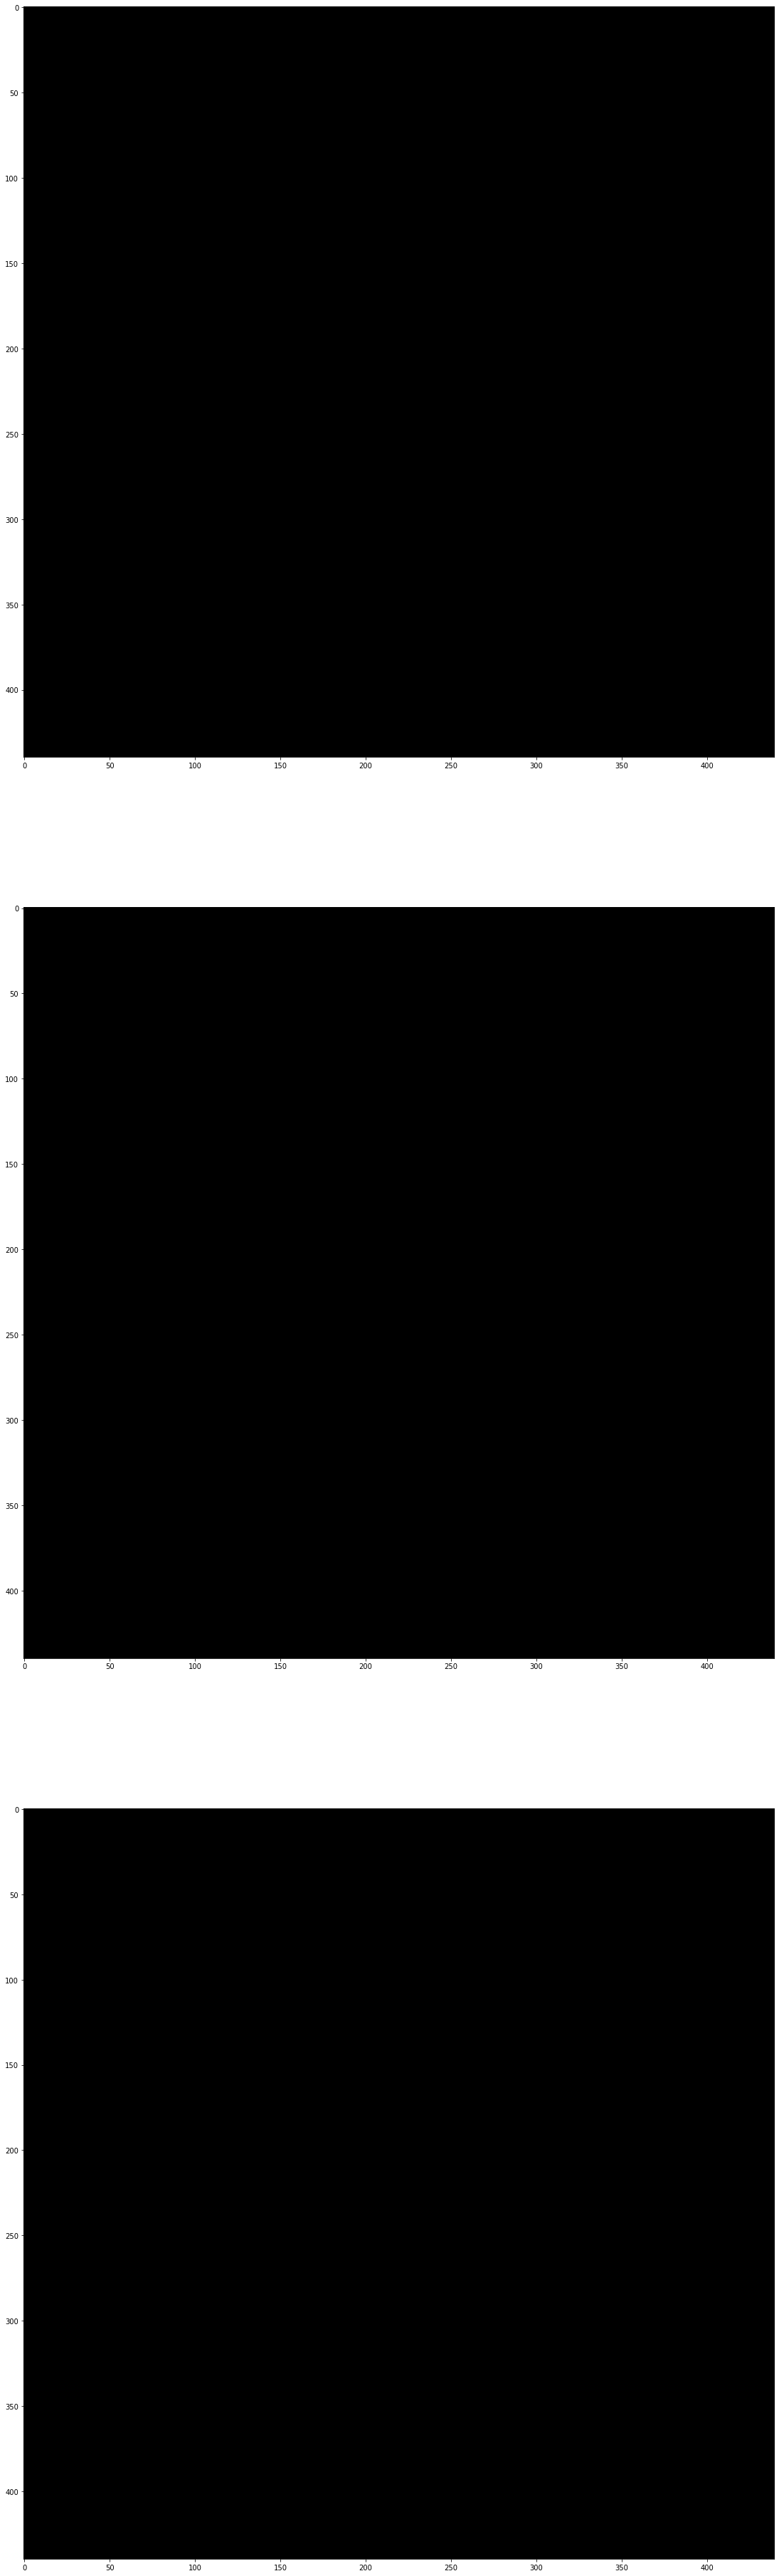

In [41]:
fig, axes = plt.subplots(3,1,figsize=(22,22*3),facecolor='w')
axes = axes.flatten()
cmap = plt.cm.viridis
cmap.set_bad(color='black')
for idx in range(len(axes)):
    ax = axes[idx]
    a=get_plot_array(original_eventdata[test_filtered_indices[middle_event_idxs[idx]],:,:,0:19])
    print(len(np.where(a>0)[0])/(440**2))
    a = np.ma.masked_where(a < 0.05, a)
    ax.imshow(a,
               origin="upper",
               cmap=cmap,
               norm=matplotlib.colors.LogNorm(vmax=np.amax(a),
                                             clip=True))
plt.show()

## Distribution of distance to wall along particle trajectory

In [42]:
# pbar = ProgressBar(widgets=['Calculating Distance to Wall. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
#            ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))
# pbar.start()
# done=0
# for dset in dataset_info:
#     d_to_wall = []
#     for i in range(dset['positions'].shape[0]):
#         pbar.update(done + i)
#         d_to_wall.append(distance_to_wall(dset['positions'][i][0],dset['angles'][i]))
#         dset['d_to_wall']=d_to_wall
#     done = done + dset['positions'].shape[0]
# pbar.finish()

In [43]:
# np.savez('./old_dataset_data/dist_to_wall.npz',train_d_to_wall=dataset_info[0]['d_to_wall'],
#                             val_d_to_wall = dataset_info[1]['d_to_wall'],
#                             test_d_to_wall = dataset_info[2]['d_to_wall'])

In [44]:
f=np.load('./old_dataset_data/dist_to_wall.npz', allow_pickle=True)
dataset_info[0]['d_to_wall'] = f['train_d_to_wall']
dataset_info[1]['d_to_wall'] = f['val_d_to_wall']
dataset_info[2]['d_to_wall'] = f['test_d_to_wall'] 

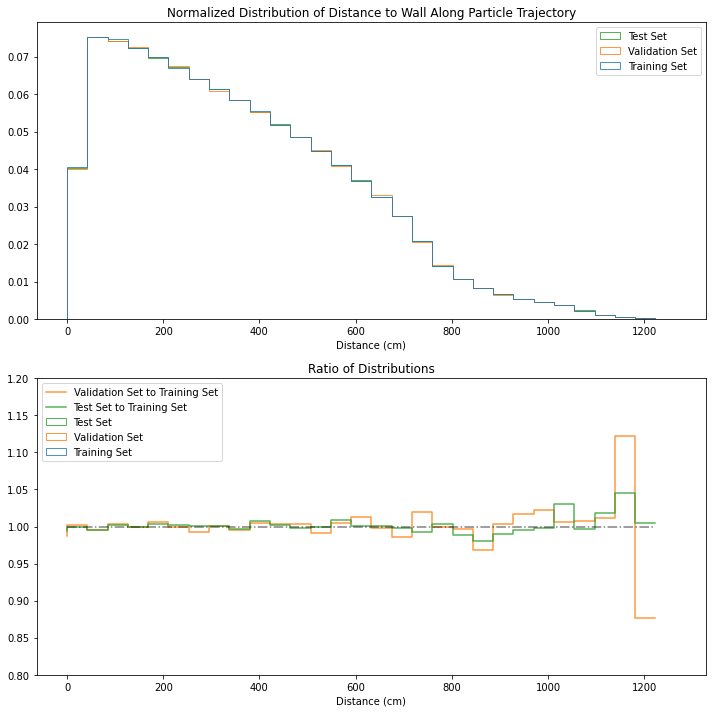

In [45]:
patches=plot_compare_dists(([data['d_to_wall'] for data in dataset_info]), [1,2],[0,0], 
                           bins=30,labels=[data['name'] for data in dataset_info],
                           title='Normalized Distribution of Distance to Wall Along Particle Trajectory',
                           ratio_range=[0.8,1.2],xlabel='Distance (cm)')

<Figure size 432x288 with 0 Axes>

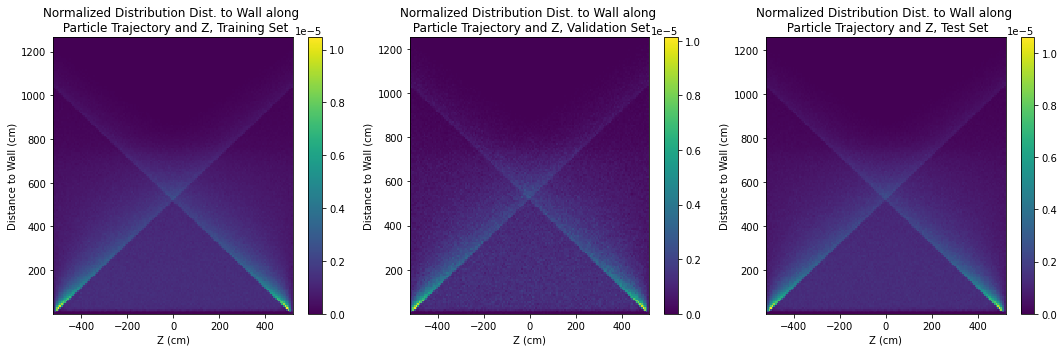

In [46]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(15,5))
for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(dataset_info[idx]['positions'][:,0,1], dataset_info[idx]['d_to_wall'],[150,150],density=True)
#     cbar = ax.colorbar(im)
    fig.colorbar(im,ax=ax)
    ax.set_title('Normalized Distribution Dist. to Wall along \n Particle Trajectory and Z, {}'.format(dataset_info[idx]['name']))
    ax.set_xlabel('Z (cm)')
    ax.set_ylabel('Distance to Wall (cm)')
plt.tight_layout()
plt.show()

../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:944: RuntimeWarning: divide by zero encountered in true_divide
  ratio = ns_1/ns_2
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:944: RuntimeWarning: invalid value encountered in true_divide
  ratio = ns_1/ns_2


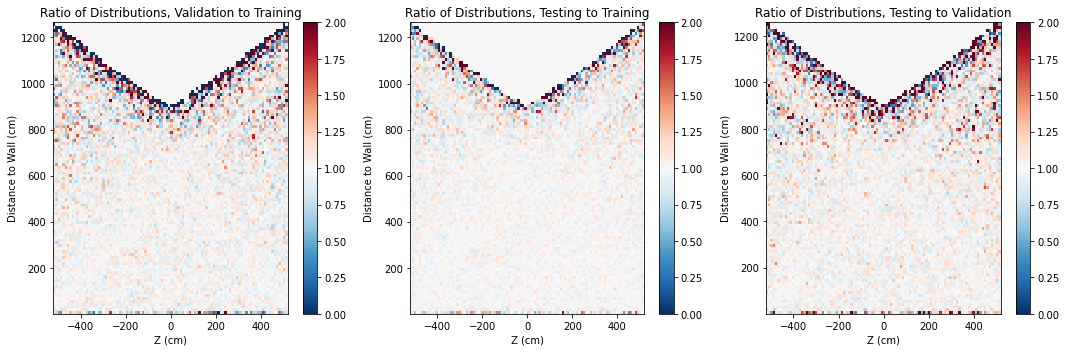

In [47]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

fig = plot_2d_ratio(dataset_info[1]['positions'][:,0,1], dataset_info[1]['d_to_wall'],
                      dataset_info[0]['positions'][:,0,1], dataset_info[0]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Validation to Training',xlabel='Z (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[0],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['positions'][:,0,1], dataset_info[2]['d_to_wall'],
                      dataset_info[0]['positions'][:,0,1], dataset_info[0]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Testing to Training',xlabel='Z (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[1],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['positions'][:,0,1], dataset_info[2]['d_to_wall'],
                      dataset_info[1]['positions'][:,0,1], dataset_info[1]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Testing to Validation',xlabel='Z (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[2],ratio_range=[0,2])
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

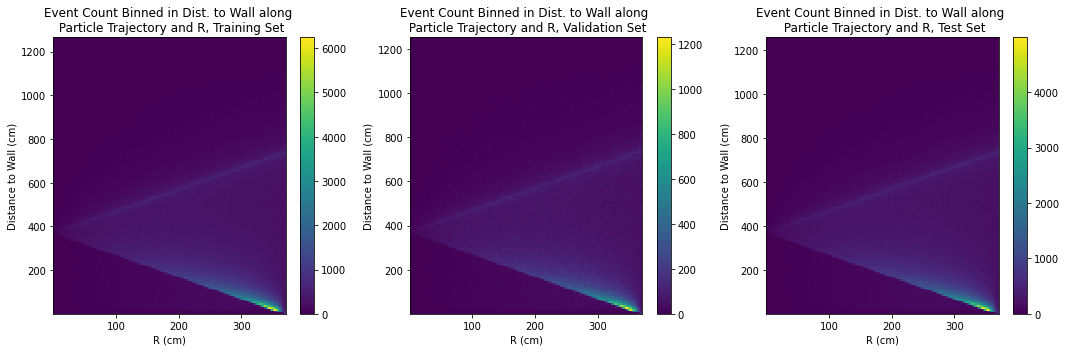

In [48]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(15,5))
for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(dataset_info[idx]['radius'], dataset_info[idx]['d_to_wall'],[150,150])
#     cbar = ax.colorbar(im)
    fig.colorbar(im,ax=ax)
    ax.set_title('Event Count Binned in Dist. to Wall along \n Particle Trajectory and R, {}'.format(dataset_info[idx]['name']))
    ax.set_xlabel('R (cm)')
    ax.set_ylabel('Distance to Wall (cm)')
plt.tight_layout()
plt.show()

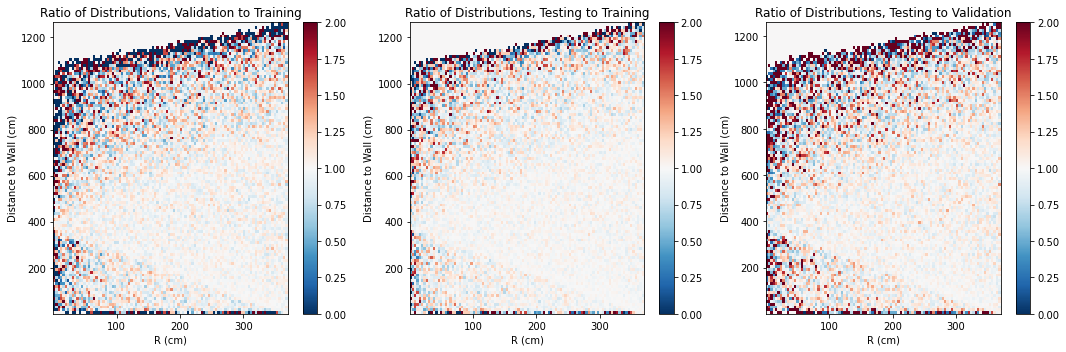

In [49]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

fig = plot_2d_ratio(dataset_info[1]['radius'], dataset_info[1]['d_to_wall'],
                      dataset_info[0]['radius'], dataset_info[0]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Validation to Training',xlabel='R (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[0],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['radius'], dataset_info[2]['d_to_wall'],
                      dataset_info[0]['radius'], dataset_info[0]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Testing to Training',xlabel='R (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[1],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['radius'], dataset_info[2]['d_to_wall'],
                      dataset_info[1]['radius'], dataset_info[1]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Testing to Validation',xlabel='R (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[2],ratio_range=[0,2])
plt.tight_layout()

# Distance to Wall by Event Type (Endcap vs Barrel)

In [50]:
"""
pbar = ProgressBar(widgets=['Calculating Event Hit Types. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))

pbar.start()
done=0
for dset in dataset_info:
    hit_types = []
    for i in range(dset['positions'].shape[0]):
        pbar.update(done + i)
        hit_types.append(deprecated_event_hit_type(dset['positions'][i][0], dset['angles'][i]))
    dset['hit_types'] = hit_types
    done = done + dset['positions'].shape[0]
pbar.finish()

np.savez('./old_dataset_data/hit_types.npz', train_hit_types= dataset_info[0]['hit_types'],
                          val_hit_types  = dataset_info[1]['hit_types'],
                          test_hit_types = dataset_info[2]['hit_types'])
"""

"\npbar = ProgressBar(widgets=['Calculating Event Hit Types. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))\n\npbar.start()\ndone=0\nfor dset in dataset_info:\n    hit_types = []\n    for i in range(dset['positions'].shape[0]):\n        pbar.update(done + i)\n        hit_types.append(deprecated_event_hit_type(dset['positions'][i][0], dset['angles'][i]))\n    dset['hit_types'] = hit_types\n    done = done + dset['positions'].shape[0]\npbar.finish()\n\nnp.savez('./old_dataset_data/hit_types.npz', train_hit_types= dataset_info[0]['hit_types'],\n                          val_hit_types  = dataset_info[1]['hit_types'],\n                          test_hit_types = dataset_info[2]['hit_types'])\n"

In [51]:
hit_type_dict = {'endcap': 0, 'barrel': 1}
f = np.load('./old_dataset_data/hit_types.npz', allow_pickle=True)

dataset_info[0]['hit_types'] = f['train_hit_types']
dataset_info[1]['hit_types'] = f['val_hit_types']
dataset_info[2]['hit_types'] = f['test_hit_types']

In [52]:
f=np.load('dist_to_wall.npz', allow_pickle=True)

dataset_info[0]['d_to_wall'] = f['train_d_to_wall']
dataset_info[1]['d_to_wall'] = f['val_d_to_wall']
dataset_info[2]['d_to_wall'] = f['test_d_to_wall'] 

FileNotFoundError: [Errno 2] No such file or directory: 'dist_to_wall.npz'

In [ ]:
# Find all endcap events
endcap_train_idxs = dataset_info[0]['hit_types'] == hit_type_dict['endcap']
endcap_val_idxs   = dataset_info[1]['hit_types'] == hit_type_dict['endcap']
endcap_test_idxs  = dataset_info[2]['hit_types'] == hit_type_dict['endcap']

# Find all barrel events
barrel_train_idxs = dataset_info[0]['hit_types'] == hit_type_dict['barrel']
barrel_val_idxs   = dataset_info[1]['hit_types'] == hit_type_dict['barrel']
barrel_test_idxs  = dataset_info[2]['hit_types'] == hit_type_dict['barrel']

In [ ]:
# Plot endcap distance to wall histogram
patches = plot_compare_dists([
                            dataset_info[0]['d_to_wall'][endcap_train_idxs],
                            dataset_info[1]['d_to_wall'][endcap_val_idxs],
                            dataset_info[2]['d_to_wall'][endcap_test_idxs]],
                            [1,2],[0,0], 
                            bins=30,labels=[data['name'] for data in dataset_info],
                            title='Normalized Distribution of Distance to Wall Along Particle Trajectory for Endcap Events',
                            ratio_range=[0.8,1.2],xlabel='Distance (cm)',
                            normalized=False)

In [ ]:
# Plot barrel distance to wall histogram
patches = plot_compare_dists([
                            dataset_info[0]['d_to_wall'][barrel_train_idxs],
                            dataset_info[1]['d_to_wall'][barrel_val_idxs],
                            dataset_info[2]['d_to_wall'][barrel_test_idxs]],
                            [1,2],[0,0], 
                            bins=30,labels=[data['name'] for data in dataset_info],
                            title='Normalized Distribution of Distance to Wall Along Particle Trajectory for Barrel Events',
                            ratio_range=[0.8,1.2],xlabel='Distance (cm)',
                            normalized=False)